In [1]:
from __future__ import print_function

import sys
import os
from glob import glob
from time import time
%matplotlib inline
#%load_ext autoreload
#%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np
import math
#plt.rcParams['figure.figsize'] = 10,8
import datetime

from   invisible_cities.database import load_db
from   invisible_cities.core.system_of_units_c import SystemOfUnits
import invisible_cities.sierpe.blr as blr
import invisible_cities.core.mpl_functions as mpl
import invisible_cities.reco.wfm_functions as wfm
import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.core.peak_functions_c as cpf
import invisible_cities.reco.pmaps_functions as pf
import invisible_cities.core.sensor_functions as sf
from   invisible_cities.core.core_functions import define_window

import invisible_cities.core.pmaps_functions_c as cpm
from   invisible_cities.core.core_functions import lrange
 
units = SystemOfUnits()
t0 = time()

In [2]:
import S1S2prop as prop
import plotting as plot

### Previous cuts diomira:
diomira: NOISE_CUT 3.5

### Previous cuts irene:
#### set_blr
NBASELINE 38000
THR_TRIGGER 5

#### set_mau
NMAU 100
THR_MAU 3

#### Set MAU thresholds for SiPM
NMAU_SIPM 100
THR_SIPM 3.5

#### set_csum
THR_CSUM_S1 0.2
THR_CSUM_S2 1.0

#### set_s1
S1_TMIN 99
S1_TMAX 101
S1_STRIDE 4
S1_LMIN 4
S1_LMAX 16

#### set_s2
S2_TMIN 101
S2_TMAX 1199
S2_STRIDE 40
S2_LMIN 80
S2_LMAX 100000

#### set_sipm
THR_SIPM_S2 30

In [3]:
#%%
#mydf_file = os.environ['IC_DATA']+'/pmaps_JM_NEW/Kr/dst_NEXT_v0_08_09_Kr_ACTIVE_10_0_7bar_pmaps_10000.root.h5'
#mydf_file = os.environ['IC_DATA']+'/irene/Kr/pmaps_NEXT_v0_08_09_Kr_ACTIVE_55_0_7bar__10000.root.h5'
#mydf_file = os.environ['IC_DATA']+'/irene/Co/pmaps_NEXT_v0_08_09_Co56_INTERNALPORTANODE_102_0_7bar__10000.root.h5'
mydf_file = os.environ['IC_DATA']+'/irene/Co/Cut3_5/pmaps_NEXT_v0_08_09_Co56_INTERNALPORTANODE_102_0_7bar__10000.root.h5'
print(mydf_file)

mydf = pf.read_pmaps(mydf_file)
#mydf
list(map(type, mydf))
S1df   = mydf[0]
S2df   = mydf[1]
S2Sidf = mydf[2]
print('S1df entries (tbins x events):',len(S1df))
print('S2df entries (tbins x events):',len(S2df))
print('S2Sidf entries:',len(S2Sidf))
type(S1df)
print('Keys of S1df panda dataframe: {} '.format(S1df.keys()))
print('Keys of S2df panda dataframe: {} '.format(S2df.keys()))
print('Keys of S2Sidf panda dataframe: {} '.format(S2Sidf.keys()))

# Convert S12df object  (an S12 pytable read as a PD dataframe) and return an S12L dictionary (list of dict, first dict)
S1dict = pf.df_to_pmaps_dict(S1df,10000)
S2dict = pf.df_to_pmaps_dict(S2df,10000)
S2Sidict = pf.df_to_s2si_dict (S2Sidf,10000)


evid_S1min = sorted(S1dict.keys())[0]
evid_S1max = sorted(S1dict.keys())[-1]
evid_S2min = sorted(S2dict.keys())[0]
evid_S2max = sorted(S2dict.keys())[-1]
evid_S2Simin = sorted(S2Sidict.keys())[0]
evid_S2Simax = sorted(S2Sidict.keys())[-1]
print('First/last event ID (first item in sorted S1 dictionary): {}/{}'.format(evid_S1min,evid_S1max))
print('First/last event ID (first item in sorted S2 dictionary): {}/{}'.format(evid_S2min,evid_S2max))
print('First/last event ID (first item in sorted S2Si dictionary): {}/{}'.format(evid_S2Simin, evid_S2Simax))
print('Total number of events in S1 = {}'.format(len(S1dict)))
print('Total number of events in S2 = {}'.format(len(S2dict)))
print('Total number of events in S2Si = {}'.format(len(S2Sidict)))
len(S1dict), type(S1dict), len(S2dict), type(S2dict), len(S2Sidict), type(S2Sidict)

/Users/neus/InvCities/data/irene/Co/Cut3_5/pmaps_NEXT_v0_08_09_Co56_INTERNALPORTANODE_102_0_7bar__10000.root.h5
S1df entries (tbins x events): 89197
S2df entries (tbins x events): 171919
S2Sidf entries: 2831424
Keys of S1df panda dataframe: Index(['event', 'peak', 'time', 'ene'], dtype='object') 
Keys of S2df panda dataframe: Index(['event', 'peak', 'time', 'ene'], dtype='object') 
Keys of S2Sidf panda dataframe: Index(['event', 'peak', 'nsipm', 'ene'], dtype='object') 
First/last event ID (first item in sorted S1 dictionary): 1/9999
First/last event ID (first item in sorted S2 dictionary): 0/9999
First/last event ID (first item in sorted S2Si dictionary): 0/9999
Total number of events in S1 = 9544
Total number of events in S2 = 9977
Total number of events in S2Si = 9855


(9544,
 invisible_cities.reco.pmap_io.S12,
 9977,
 invisible_cities.reco.pmap_io.S12,
 9855,
 invisible_cities.reco.pmap_io.S2Si)

In [4]:
#table = tb.open_file(mydf_file,mode='r')

In [5]:
#table

In [6]:
S1 = prop.S12Prop(S1dict)
S2 = prop.S12Prop(S2dict)

type(S1)
S2.length, S1.length
S1.dict().keys() == S2.dict().keys()

False

In [7]:
S1map = S1.S1S2mapd(S2)[0]
S2map = S1.S1S2mapd(S2)[1]
S1map.dict().keys() == S2map.dict().keys()

True

In [8]:
S1map.length

9543

## S1 features

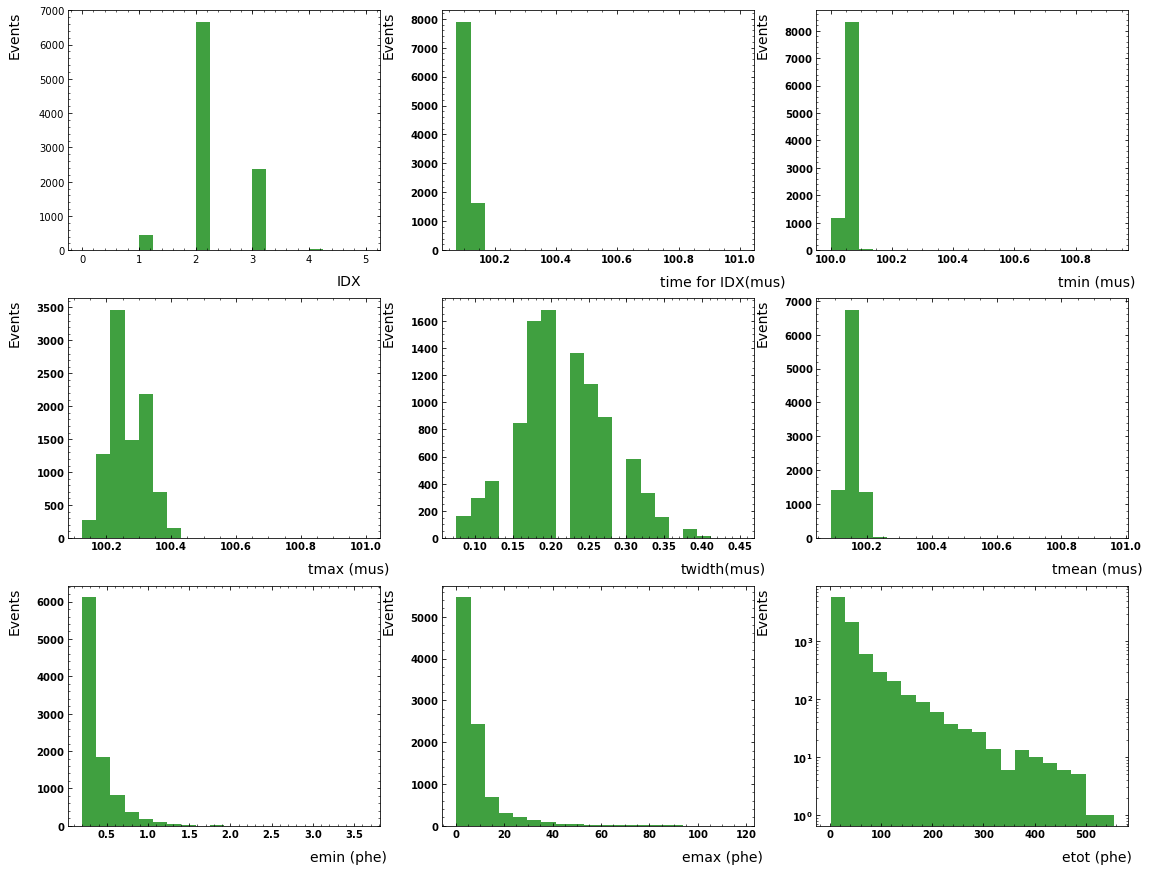

In [9]:
fig = plt.figure(figsize = (19,15))
ax1 = fig.add_subplot(3,3,1)
plot.multh1(S1map.IDX, 20,    ax1, color="green", title="", xlabel ="IDX", ylabel = "Events")
#ax1.set_yscale('log')
ax2 = fig.add_subplot(3,3,2)
plot.multh1(S1map.tIDX, 20,   ax2, color="green", title="", xlabel ="time for IDX(mus)", ylabel = "Events")
ax3 = fig.add_subplot(3,3,3)
plot.multh1(S1map.tmin, 20,   ax3, color="green", title="", xlabel ="tmin (mus)", ylabel = "Events")
ax4 = fig.add_subplot(3,3,4)
plot.multh1(S1map.tmax, 20,   ax4, color="green", title="", xlabel ="tmax (mus)", ylabel = "Events")
ax5 = fig.add_subplot(3,3,5)
plot.multh1(S1map.twidth, 20, ax5, color="green", title="", xlabel ="twidth(mus)", ylabel = "Events")
ax6 = fig.add_subplot(3,3,6)
plot.multh1(S1map.tmean, 20,  ax6, color="green", title="", xlabel ="tmean (mus)", ylabel = "Events")
ax7 = fig.add_subplot(3,3,7)
plot.multh1(S1map.emin, 20,   ax7, color="green", title="", xlabel ="emin (phe)", ylabel = "Events")
ax8 = fig.add_subplot(3,3,8)
plot.multh1(S1map.emax, 20,   ax8, color="green", title="", xlabel ="emax (phe)", ylabel = "Events")
ax9 = fig.add_subplot(3,3,9)
plot.multh1(S1map.etot, 20,   ax9, color="green", title="", xlabel ="etot (phe)", ylabel = "Events")
ax9.set_yscale('log')

## S2 features

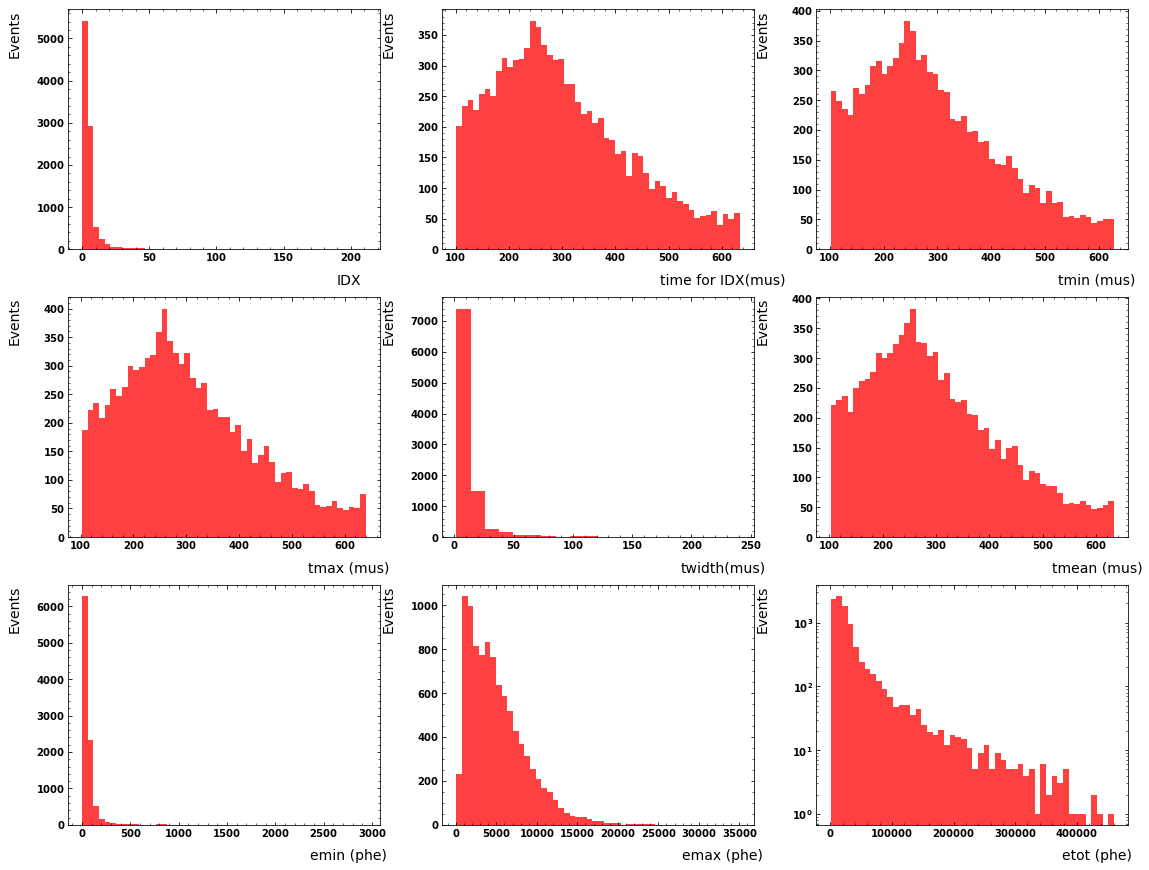

In [10]:
fig = plt.figure(figsize = (19,15))
ax1 = fig.add_subplot(3,3,1)
plot.multh1(S2map.IDX, 50,    ax1, color="red", title="", xlabel ="IDX", ylabel = "Events")
#ax1.set_yscale('log')
ax2 = fig.add_subplot(3,3,2)
plot.multh1(S2map.tIDX, 50,   ax2, color="red", title="", xlabel ="time for IDX(mus)", ylabel = "Events")
ax3 = fig.add_subplot(3,3,3)
plot.multh1(S2map.tmin, 50,   ax3, color="red", title="", xlabel ="tmin (mus)", ylabel = "Events")
ax4 = fig.add_subplot(3,3,4)
plot.multh1(S2map.tmax, 50,   ax4, color="red", title="", xlabel ="tmax (mus)", ylabel = "Events")
ax5 = fig.add_subplot(3,3,5)
plot.multh1(S2map.twidth, 20, ax5, color="red", title="", xlabel ="twidth(mus)", ylabel = "Events")
ax6 = fig.add_subplot(3,3,6)
plot.multh1(S2map.tmean, 50,  ax6, color="red", title="", xlabel ="tmean (mus)", ylabel = "Events")
ax7 = fig.add_subplot(3,3,7)
plot.multh1(S2map.emin, 50,   ax7, color="red", title="", xlabel ="emin (phe)", ylabel = "Events")
ax8 = fig.add_subplot(3,3,8)
plot.multh1(S2map.emax, 50,   ax8, color="red", title="", xlabel ="emax (phe)", ylabel = "Events")
ax9 = fig.add_subplot(3,3,9)
plot.multh1(S2map.etot, 50,   ax9, color="red", title="", xlabel ="etot (phe)", ylabel = "Events")
ax9.set_yscale('log')

<module 'matplotlib.pyplot' from '/Users/neus/miniconda/envs/IC3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

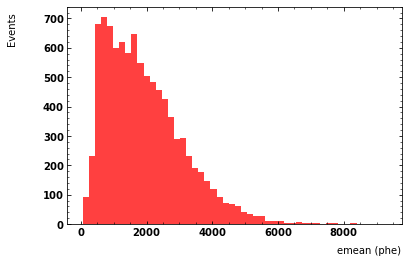

In [11]:
plot.h1(S2map.emean, 50,   color="red", title="", xlabel ="emean (phe)", ylabel = "Events")

In [12]:
z = S2map.tIDX - S1map.tIDX

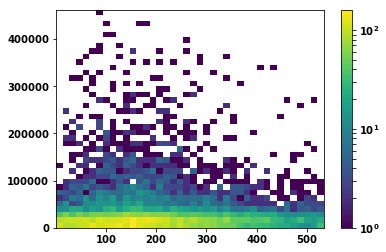

In [13]:
from matplotlib.colors import LogNorm
plt.hist2d(z, S2map.etot, bins=40, norm=LogNorm())
plt.colorbar()
plt.show()

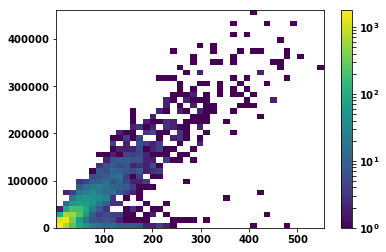

In [14]:
plt.hist2d(S1map.etot, S2map.etot, bins=40, norm=LogNorm())
plt.colorbar()
plt.show()

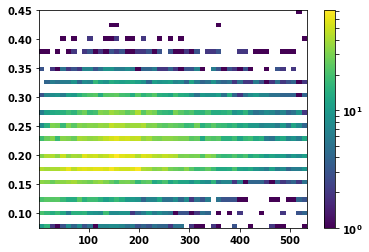

In [15]:
plt.hist2d(z,S1map.twidth, bins=50, norm=LogNorm())
plt.colorbar()
plt.show()

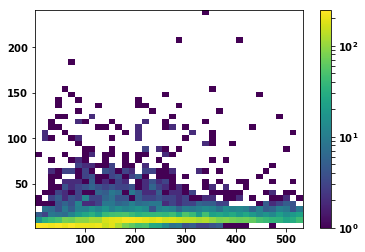

In [16]:
plt.hist2d(z,S2map.twidth, bins=40, norm=LogNorm())
plt.colorbar()
plt.show()

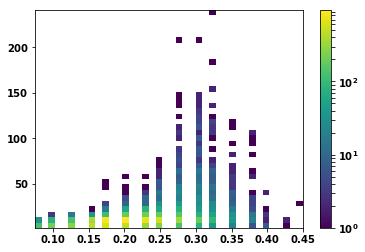

In [17]:
plt.hist2d(S1map.twidth,S2map.twidth, bins=40, norm=LogNorm())
plt.colorbar()
plt.show()

## S2Si features 

### first, obtain intersection of dicts:

In [18]:
filt_dict = lambda x, y: dict([ (i , x[i] ) for i in x if i in set(y) ])
      
keys_S1 = set(S1dict.keys())
keys_S2 = set(S2dict.keys())
intsect = keys_S1 & keys_S2

S1map   = filt_dict(S1dict,intsect)
S2map   = filt_dict(S2dict,intsect)

In [19]:
keys_S2map =  set(S2map.keys())
keys_S2Si  =  set(S2Sidict.keys())
intsect = keys_S2map & keys_S2Si

S2map_Si = filt_dict(S2map,intsect)
S2Simap  = filt_dict(S2Sidict,intsect)

In [20]:
len(S2map_Si)

9523

In [21]:
S2map_Si.keys() == S2Simap.keys() 

True

In [22]:
S2map.keys() == S2map_Si.keys()

False

In [23]:
len(S2map) 

9543

In [24]:
len(S2Sidict)

9855

In [25]:
len(S2Simap) == 8963 == len(S2map_Si)

False

In [26]:
s2si = prop.S2SiProp(S2Simap)

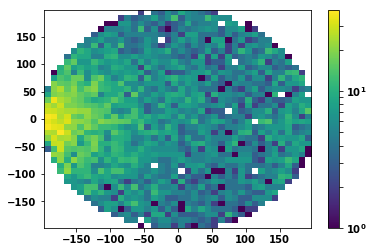

In [27]:
from matplotlib.colors import LogNorm
plt.hist2d(s2si.x, s2si.y, bins=40, norm=LogNorm())
plt.colorbar()
plt.show()

(array([ 1512.,  1455.,  1204.,  1025.,   917.,   849.,   727.,   663.,
          650.,   471.]),
 array([-198.36714257, -158.84260613, -119.31806969,  -79.79353325,
         -40.26899682,   -0.74446038,   38.78007606,   78.3046125 ,
         117.82914894,  157.35368538,  196.87822182]),
 <a list of 10 Patch objects>)

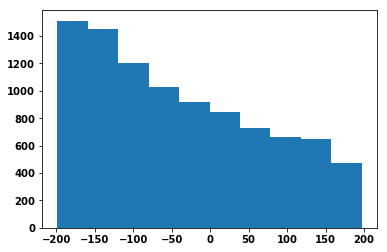

In [28]:
plt.hist(s2si.x)

(array([ 13764.,  13611.,  12036.,  10022.,   9291.,   9990.,   6681.,
          7607.,   7470.,   2654.]),
 array([-205., -163., -121.,  -79.,  -37.,    5.,   47.,   89.,  131.,
         173.,  215.]),
 <a list of 10 Patch objects>)

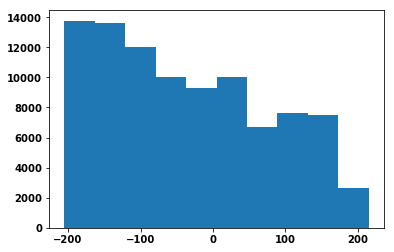

In [29]:
plt.hist(s2si.xsipms)

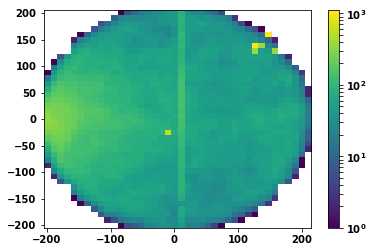

In [30]:
from matplotlib.colors import LogNorm
plt.hist2d(s2si.xsipms, s2si.ysipms, bins=40, norm=LogNorm())
plt.colorbar()
plt.show()

### Open the pytable file for MC truth extraction 

In [31]:
table = tb.open_file(mydf_file,mode='r')

In [32]:
table.root

/ (RootGroup) ''
  children := ['Run' (Group), 'PMAPS' (Group), 'MC' (Group)]

In [33]:
table_truth = table.root.MC.MCTracks
table = table_truth[:]

In [36]:
from collections import namedtuple
def xxx (mctruth_table, max_events=None):
    
    result = {}
    Tuple = namedtuple('sipms','momentum, position, energies, hit_energies')
    len_mc_truth_table = len(mctruth_table)

#    convert table to numpy.ndarray
    data       = mctruth_table[:]
    data_size  = len(data)

    event            =  data["event_indx"]
    particle         =  data["mctrk_indx"]
    particle_name    =  data["particle_name"]
    pdg_code         =  data["pdg_code"]
    initial_vertex   =  data["initial_vertex"]
    final_vertex     =  data["final_vertex"]
    momentum         =  data["momentum"]
    energy           =  data["energy"]
    nof_hits         =  data["nof_hits"]
    hit              =  data["hit_indx"]
    hit_position     =  data["hit_position"]
    hit_time         =  data["hit_time"]
    hit_energy       =  data["hit_energy"]

    event_boundary    = True
    particle_boundary = True
    hit_boundary      = True

    current_event    = -2
    current_particle = -1
    current_hit      = -1

    limit = np.iinfo(int).max if max_events is None or max_events < 0 else max_events
    
    for i in range(data_size):
       # print('+++++++++start loop = {}, event= {}, particle= {}, hit= {}'.format(i,event[i], particle[i], hit[i]))
        
        if(event_boundary):    # start new event
            current_event = event[i]
            #print('-----current event= {}'.format(current_event))
            if current_event >= limit: break
            event_data = {}

        if particle_boundary:  # Start new particle
            current_particle = particle[i]
            particle_data = {}

        if hit_boundary:  # Start new hit
            current_hit = hit[i]
            momentums, hit_positions, energies, hit_energies = [], [], [], []
           
           

       # Add position, momentum to current particle's data  
       
        momentums     .append(momentum    [i])
        hit_positions .append(hit_position[i])
        energies      .append(energy      [i])
        hit_energies  .append(hit_energy  [i])
      
        #print(momentum)

        event_boundary     = i+1 == data_size     or event     [i+1] != current_event
        particle_boundary  = event_boundary       or particle [i+1]  != current_particle
        hit_boundary       = particle_boundary    or hit      [i+1]  != current_hit
        
        if hit_boundary:  # End of hit: save it
            particle_data[current_hit] = Tuple(np.array(momentums), 
                                               np.array(hit_positions), 
                                               np.array(energies), 
                                               np.array(hit_energies))
            
        if particle_boundary:  # End of particle: save it
            #print('end of particle')
            event_data[current_particle] = particle_data


        if event_boundary: # End of event: save it
            #print('end of event')
            result[current_event] = event_data
       
    
    return result




In [37]:
Truth_dict = xxx(table)

### Intersect Truth-dict with S2Si-reco-dict


In [38]:
keys_Truth_dict =  set(Truth_dict.keys())
keys_S2Si  =  set(S2Sidict.keys())
intsect = keys_Truth_dict & keys_S2Si

Truth_dict_map = filt_dict(Truth_dict,intsect)
S2Simap  = filt_dict(S2Sidict,intsect)

In [39]:
T = prop.Truth_S2SiProp(Truth_dict_map)

In [40]:
len(Truth_dict_map)

9852

(array([  115.,   137.,    58.,    49.,  2533.,  2024.,  1587.,  1340.,
         1140.,   869.]),
 array([-462.56411743, -396.61137695, -330.65863647, -264.705896  ,
        -198.75315552, -132.80041504,  -66.84767456,   -0.89493408,
          65.0578064 ,  131.01054687,  196.96328735]),
 <a list of 10 Patch objects>)

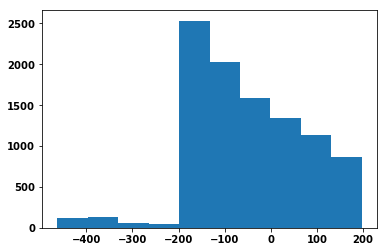

In [41]:
plt.hist(T.xtruth)

(array([  324.,   637.,   910.,  1270.,  1821.,  1762.,  1282.,   889.,
          622.,   335.]),
 array([-197.80412292, -158.30317078, -118.80221863,  -79.30126648,
         -39.80031433,   -0.29936218,   39.20158997,   78.70254211,
         118.20349426,  157.70444641,  197.20539856]),
 <a list of 10 Patch objects>)

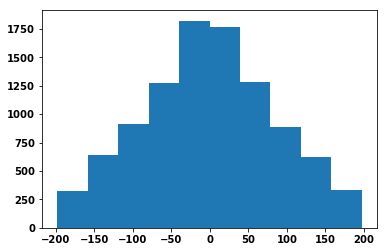

In [42]:
plt.hist(T.ytruth)

(array([  3.11773000e+05,   6.48310000e+04,   2.66460000e+04,
          1.21910000e+04,   5.43000000e+03,   2.15700000e+03,
          6.91000000e+02,   9.30000000e+01,   1.20000000e+01,
          4.00000000e+00]),
 array([  1.87856403e-06,   3.77426241e-01,   7.54850603e-01,
          1.13227497e+00,   1.50969933e+00,   1.88712369e+00,
          2.26454805e+00,   2.64197241e+00,   3.01939678e+00,
          3.39682114e+00,   3.77424550e+00]),
 <a list of 10 Patch objects>)

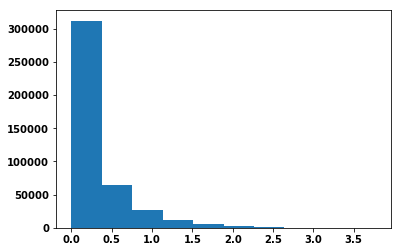

In [43]:
plt.hist(T.edepo)

(array([  3.96860000e+04,   1.14500000e+03,   3.46000000e+02,
          1.37000000e+02,   6.80000000e+01,   3.70000000e+01,
          1.70000000e+01,   5.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([  5.15000011e-06,   2.90453968e-01,   5.80902786e-01,
          8.71351605e-01,   1.16180042e+00,   1.45224924e+00,
          1.74269806e+00,   2.03314688e+00,   2.32359570e+00,
          2.61404451e+00,   2.90449333e+00]),
 <a list of 10 Patch objects>)

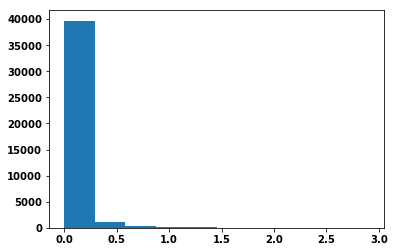

In [44]:
plt.hist(T.energies)

(array([   3455.,       0.,       0.,       0.,   89202.,  100403.,
          80222.,   64876.,   51093.,   34577.]),
 array([-485.10540771, -416.79490814, -348.48440857, -280.173909  ,
        -211.86340942, -143.55290985,  -75.24241028,   -6.93191071,
          61.37858887,  129.68908844,  197.99958801]),
 <a list of 10 Patch objects>)

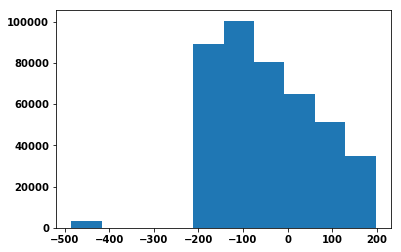

In [45]:
plt.hist(T.xposition)

(array([ 10989.,  22864.,  35995.,  56817.,  84065.,  82185.,  57816.,
         37346.,  24238.,  11513.]),
 array([ -1.97997620e+02,  -1.58409218e+02,  -1.18820816e+02,
         -7.92324142e+01,  -3.96440125e+01,  -5.56106567e-02,
          3.95327911e+01,   7.91211929e+01,   1.18709595e+02,
          1.58297997e+02,   1.97886398e+02]),
 <a list of 10 Patch objects>)

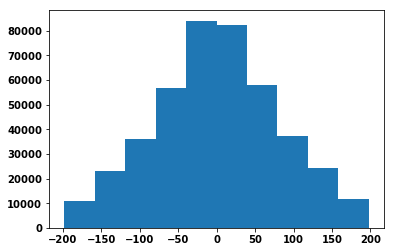

In [46]:
plt.hist(T.yposition)

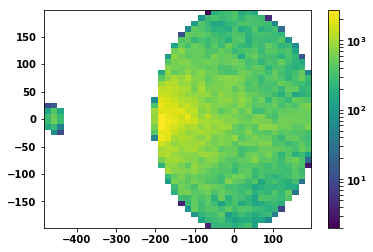

In [47]:
from matplotlib.colors import LogNorm
plt.hist2d(T.xposition, T.yposition, bins=40, norm=LogNorm())
plt.colorbar()
plt.show()

In [48]:
## Truth-reco comparison